Source: https://www.kaggle.com/code/mahmoudelfahl/cohort-analysis-customer-segmentation-with-rfm/notebook

In [16]:
#libraries
import pandas as pd 
import numpy as np 
import datetime as dt 
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Import Dataset

In [2]:
df = pd.read_csv('online_retail.csv')

Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

# Explore & Clean Dataset

In [17]:
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom


In [5]:
df.shape

(1067371, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [8]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [50]:
df.describe()

,Quantity,Price,Customer ID
count,779425.00,779425.00,779425.00
mean,13.49,3.22,15320.36
std,145.86,29.68,1695.69
min,1.00,0.00,12346.00
25%,2.00,1.25,13971.00
50%,6.00,1.95,15247.00
75%,12.00,3.75,16794.00
max,80995.00,10953.50,18287.00


In [26]:
# verify orders cancelled
df['Invoice'].str.contains('C',na=False).sum()

19494

In [47]:
df.duplicated().sum()

26124

Asks:
1. Converter InvoiceDate para Datetime
2. Dropar valores nulos
3. Excluir orders canceladas do dataset
4. Validar Quantity e Price negativos
5. Excluir valores duplicados

In [14]:
# 1. Converter InvoiceDate para Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [27]:
# 2. Dropar valores nulos
df.dropna(inplace=True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [32]:
# 3. Excluir orders canceladas do dataset
df = df[~df['Invoice'].str.contains('C',na=False)]

In [51]:
# 4. Validar Quantity e Price negativos
df = df[(df['Price']>0) & (df['Quantity']>0)]

In [53]:
# 5. Excluir valores duplicados
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [56]:
df.shape

(779425, 8)

# Cohort Data Prepare

In [58]:
# create column with month
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda x: dt.datetime(x.year,x.month,1))
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01


In [69]:
# create group and Cohort Month
# identify the cohort month for each customer
df['CohortMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,2009-12-01,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01,2009-12-01


In [71]:
# create function to get date information
def get_month_int(dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

In [74]:
# create Cohort Index
InvoiceYear, InvoiceMonth, _ = get_month_int(df,'InvoiceMonth')
CohortYear, CohortMonth, _ = get_month_int(df,'CohortMonth')

YearDiff = InvoiceYear - CohortYear
MonthDiff = InvoiceMonth - CohortMonth

df['CohortIndex'] = YearDiff * 12 + MonthDiff + 1
df.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,2009-12-01,2009-12-01,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01,2009-12-01,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,2009-12-01,2009-12-01,1


In [87]:
# create cohort by active users
df_cohort = df.groupby(['CohortMonth','CohortIndex'])['Customer ID'].apply(pd.Series.nunique)
df_cohort = df_cohort.reset_index()
df_counts = pd.pivot(df_cohort,index='CohortMonth',columns='CohortIndex',values='Customer ID')
df_counts.head(3)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
CohortMonth,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01,955.00,337.00,319.00,406.00,363.00,343.00,360.00,327.00,321.00,346.00,403.00,473.00,359.00,270.00,233.00,289.00,251.00,289.00,270.00,248.00,244.00,301.00,291.00,389.00,188.00
2010-01-01,383.00,79.00,119.00,117.00,101.00,115.00,99.00,88.00,107.00,122.00,116.00,66.00,85.00,68.00,72.00,58.00,90.00,76.00,71.00,75.00,93.00,74.00,94.00,22.00,NaN
2010-02-01,374.00,89.00,84.00,109.00,92.00,75.00,72.00,107.00,95.00,103.00,43.00,47.00,57.00,65.00,46.00,75.00,60.00,61.00,54.00,86.00,86.00,61.00,22.00,NaN,NaN


In [107]:
# cohort retention percentage
cohort_size = df_counts.iloc[:,0]
retention = df_counts.divide(cohort_size,axis=0) #axis = 0 to divide along the row 
retention.round(3) * 100
retention.index = retention.index.date
retention.head(3)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
2009-12-01,1.00,0.35,0.33,0.43,0.38,0.36,0.38,0.34,0.34,0.36,0.42,0.50,0.38,0.28,0.24,0.30,0.26,0.30,0.28,0.26,0.26,0.32,0.30,0.41,0.20
2010-01-01,1.00,0.21,0.31,0.31,0.26,0.30,0.26,0.23,0.28,0.32,0.30,0.17,0.22,0.18,0.19,0.15,0.23,0.20,0.19,0.20,0.24,0.19,0.25,0.06,NaN
2010-02-01,1.00,0.24,0.22,0.29,0.25,0.20,0.19,0.29,0.25,0.28,0.11,0.13,0.15,0.17,0.12,0.20,0.16,0.16,0.14,0.23,0.23,0.16,0.06,NaN,NaN


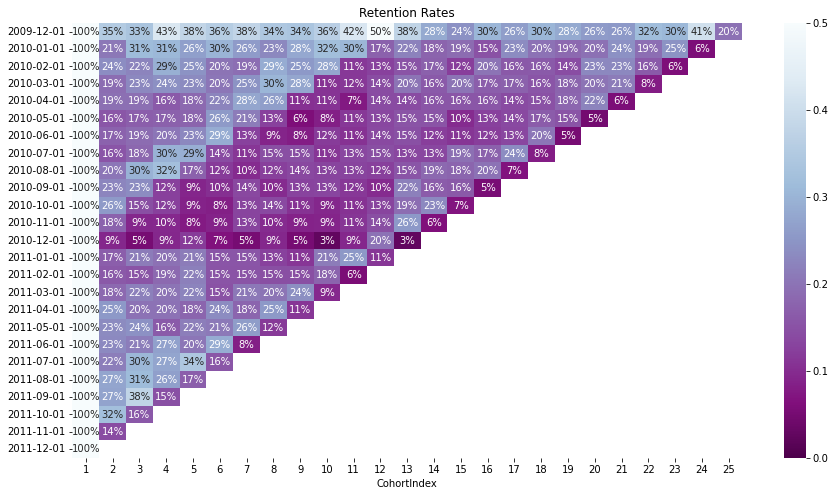

In [108]:
# Heatmap
plt.figure(figsize=(15,8))
plt.title('Retention Rates')
sns.heatmap(data=retention,annot=True,fmt='.0%',vmin=0.0,vmax=0.5,cmap='BuPu_r')
plt.show()

In [106]:
# cohort by quantity
df_qcohort = df.groupby(['CohortMonth','CohortIndex'])['Quantity'].mean()
df_qcohort = df_qcohort.reset_index()
df_qcohort.head(3)

,CohortMonth,CohortIndex,Quantity
0,2009-12-01,1,13.17
1,2009-12-01,2,23.35
2,2009-12-01,3,21.62


In [109]:
# table average quantity
average_quantity = pd.pivot(df_qcohort,index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.index = average_quantity.index.date 
average_quantity.round(1)

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
2009-12-01,13.20,23.40,21.60,22.60,13.60,15.30,14.30,14.40,26.50,17.60,16.10,14.20,13.90,24.60,17.70,15.30,13.90,15.30,16.80,15.40,19.40,16.70,19.30,13.80,15.20
2010-01-01,9.60,14.20,9.70,13.30,13.10,13.30,12.20,12.80,12.40,13.00,11.00,14.90,11.00,9.80,14.90,15.60,13.20,13.20,16.30,13.40,14.40,14.90,10.10,9.30,NaN
2010-02-01,10.10,10.10,16.10,13.20,10.30,12.20,12.30,10.70,9.60,10.20,11.20,8.60,12.40,11.50,8.80,11.60,11.00,18.00,10.20,11.00,10.00,8.90,11.90,NaN,NaN
2010-03-01,10.40,13.80,11.90,13.40,11.00,13.70,13.20,11.70,11.90,14.70,10.10,10.90,13.30,12.40,13.30,10.80,14.00,12.00,14.10,9.40,12.00,10.50,NaN,NaN,NaN
2010-04-01,10.70,9.00,10.50,14.60,12.60,10.40,10.40,9.90,10.10,10.30,9.20,13.30,9.60,12.50,10.80,13.40,14.80,11.50,10.30,9.50,10.60,NaN,NaN,NaN,NaN
2010-05-01,12.20,9.40,10.30,12.50,13.10,9.40,7.60,6.90,11.30,11.50,8.80,12.10,11.10,11.70,14.50,11.60,14.80,9.90,8.80,7.90,NaN,NaN,NaN,NaN,NaN
2010-06-01,10.90,8.90,13.60,10.80,11.50,14.20,11.40,17.90,32.20,28.40,20.50,19.90,23.70,18.70,26.70,18.40,13.10,10.40,12.30,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,8.50,8.90,7.30,8.90,7.40,7.20,8.40,9.50,7.90,7.30,9.00,11.70,10.50,12.60,8.40,8.40,7.90,12.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,8.30,8.80,8.90,7.60,10.50,7.60,8.30,7.90,12.80,15.90,9.20,5.80,9.80,12.10,13.20,11.10,12.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,27.30,10.60,8.30,10.80,16.20,8.20,14.10,12.00,20.60,14.60,17.40,17.70,30.50,10.70,14.00,9.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


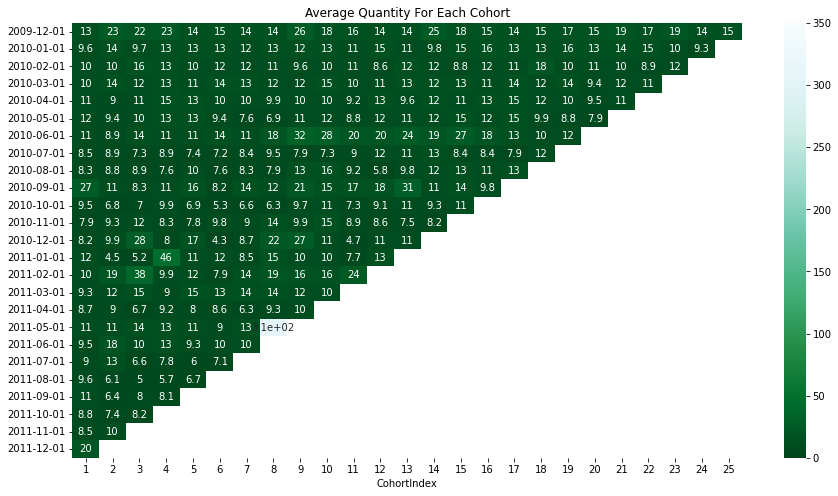

In [111]:
# Heatmap
plt.figure(figsize=(15,8))
plt.title('Average Quantity For Each Cohort')
sns.heatmap(data=average_quantity,annot=True,vmin=0,vmax=350,cmap='BuGn_r')
plt.show()